In [2]:
import xarray as xr
import pandas as pd
import arviz as az
import bambi as bmb
import pymc as pm
import graphviz as gv
import matplotlib.pyplot as plt

#### Overview
This project will be a continuation of the previous one. I had already begun using GLMs with multiple predictors, but this time I will be refining that. I had previously taken a lot of data and only used very little of it, so I'll begin by importing that.

In [3]:
data = pd.read_csv('seedscraper_out.csv')
data.drop(index=list(range(1000, 5000)), inplace=True)
data["isPos"] = [t > 0 for t in data.villageTemperature]
data

,seed,spawnBiome,spawnX,spawnZ,spawnMag,distance,percentage,biome,X,Z,...,originDepth,originWeirdness,villageTemperature,villageHumidity,villageContinentalness,villageErosion,villageDepth,villageWeirdness,debug,isPos
0,-5732824298624648829,desert,-61,19,63.890531,13.152946,0.0,desert,144,48,...,1.0,-0.035057,0.885496,-0.087994,0.126685,0.477075,-0.5625,0.432049,Near inland,True
1,476111214681048185,snowy_taiga,0,32,32.000000,24.186773,0.0,taiga,336,-160,...,1.0,0.139197,-0.709614,0.428070,-0.090090,0.594332,-0.5625,-0.106672,Mid inland,False
2,1013578317724244864,grove,-14,397,397.246775,41.868843,0.0,snowy_plains,-448,896,...,1.0,-0.109274,-0.776016,0.059834,0.233475,-0.319886,-0.5625,0.659344,Near inland,False
3,3540650499908179768,plains,43,-58,72.201108,14.317821,0.0,plains,240,-160,...,1.0,-0.080760,0.113077,-0.250954,-0.022128,-0.122485,-0.5625,-0.273975,Near inland,True
4,-288261298075803855,old_growth_birch_forest,-27,126,128.860390,48.877398,0.0,plains,368,784,...,1.0,-0.000875,-0.192036,-0.475988,0.230019,0.295004,-0.5625,-0.902690,Coast,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5466505011541562565,snowy_slopes,28,-125,128.097619,17.204651,0.0,snowy_plains,240,-288,...,1.0,-0.057639,-0.932037,-0.107090,0.153090,-0.302736,-0.5625,0.096465,Near inland,False
996,-5548836884937564074,grove,0,0,0.000000,33.615473,0.0,plains,208,-496,...,1.0,-0.469792,0.021880,-0.217357,0.354111,-0.352449,-0.5625,-0.206148,Mid inland,True
997,-40197854004093186,savanna,-44,-107,115.693561,17.492856,0.0,savanna,-288,32,...,1.0,-0.230311,0.448744,-0.180282,0.167955,-0.173869,-0.5625,-0.191847,Near inland,True
998,8820738196167999944,beach,345,773,846.495127,63.694584,0.0,plains,720,1712,...,1.0,-0.050626,-0.247186,-0.411894,0.004538,0.089136,-0.5625,0.302828,Coast,False


#### Causal Diagram
First, we need to analyze the variables. There are a few separate instances of these 6 climate variables, so I made a function to run through all of them. I added every connection I could think of, then graphed it.

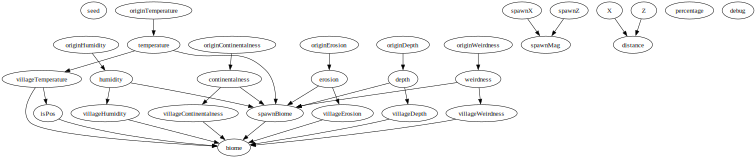

In [4]:
g = gv.Digraph(graph_attr={"size": "10.5,10!"})
for col in data: g.node(col)

def all(tail, head):
    for s in ["temperature", "humidity", "continentalness", "erosion", "depth", "weirdness"]:
        g.edge(tail.replace("{}", s).replace("{C}", s.capitalize()), head.replace("{}", s).replace("{C}", s.capitalize()))

all("{}", "spawnBiome")
all("origin{C}", "{}")
all("{}", "village{C}")
all("village{C}", "biome")
g.edge("spawnBiome", "biome")
g.edge("spawnX", "spawnMag")
g.edge("spawnZ", "spawnMag")
g.edge("X", "distance")
g.edge("Z", "distance")
g.edge("villageTemperature", "isPos")
g.edge("isPos", "biome")

g

#### Diagram Analysis
Well granted that I am trying to predict things about villages, it makes sense that everything would point to the village biome. That seems like a natural variable to predict. Beyond that, it looks like every climate variable has a hierarchy back to the origin version. Looks like the non-climate-related variables won't be too useful, so I'll leave those off. To start, we can *try* one with all the climate variables. Note that I'm not using `spawnBiome` because predicting using a categorical gets more painful, and that information is already encoded in the various spawn climate variables.

In [5]:
# depth is constant; removed
model_all = bmb.Model("biome ~ villageTemperature + villageHumidity + villageContinentalness + villageErosion + villageWeirdness + temperature + humidity + continentalness + erosion + weirdness + originTemperature + originHumidity + originContinentalness + originErosion + originWeirdness + (villageTemperature|temperature) + (temperature|originTemperature) + (villageHumidity|humidity) + (humidity|originHumidity) + (villageContinentalness|continentalness) + (continentalness|originContinentalness) + (villageErosion|erosion) + (erosion|originErosion) + (villageWeirdness|weirdness) + (weirdness|originWeirdness)", data=data, family="categorical")
idata_all = model_all.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, villageTemperature, villageHumidity, villageContinentalness, villageErosion, villageWeirdness, temperature, humidity, continentalness, erosion, weirdness, originTemperature, originHumidity, originContinentalness, originErosion, originWeirdness, 1|temperature_sigma, 1|temperature_offset, villageTemperature|temperature_sigma, villageTemperature|temperature_offset, 1|originTemperature_sigma, 1|originTemperature_offset, temperature|originTemperature_sigma, temperature|originTemperature_offset, 1|humidity_sigma, 1|humidity_offset, villageHumidity|humidity_sigma, villageHumidity|humidity_offset, 1|originHumidity_sigma, 1|originHumidity_offset, humidity|originHumidity_sigma, humidity|originHumidity_offset, 1|continentalness_sigma, 1|continentalness_offset, villageContinentalness|continentalness_sigma, villageContinentalness|continentalness_offset, 1|originContinentalness_sigma, 1|originCo

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 896 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


#### Additional Models
Before running any checks, there's a couple other models I'd like to use for comparison. First, last project determined that temperature alone is a pretty good predictor. I'm going to try one model that only uses the temperature chain, to check for overfitting with all the climate variables.

In [6]:
model_temp_chain = bmb.Model("biome ~ villageTemperature + temperature + originTemperature + (villageTemperature|temperature) + (temperature|originTemperature)", data=data, family="categorical")
idata_temp_chain = model_temp_chain.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, villageTemperature, temperature, originTemperature, 1|temperature_sigma, 1|temperature_offset, villageTemperature|temperature_sigma, villageTemperature|temperature_offset, 1|originTemperature_sigma, 1|originTemperature_offset, temperature|originTemperature_sigma, temperature|originTemperature_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 173 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


I'd also like to try one without any of the hierarchies, for a couple reasons. One, just to make sure I'm not overfitting. Two, ideally this model would be able to predict village biome solely off of information available at spawn. Using only those variables makes that possible. I'm going to do a couple here; one with all the spawn climate variables, and one with just temperature.

In [7]:
model_spawn = bmb.Model("biome ~ temperature + humidity + continentalness + erosion + weirdness", data=data, family="categorical")
idata_spawn = model_spawn.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, temperature, humidity, continentalness, erosion, weirdness]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


In [8]:
model_spawn_temp = bmb.Model("biome ~ temperature", data=data, family="categorical")
idata_spawn_temp = model_spawn_temp.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, temperature]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


#### Comparison
Time to compare. I'll start with an elpd_loo comparison before checking predictions and PPCs.

/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

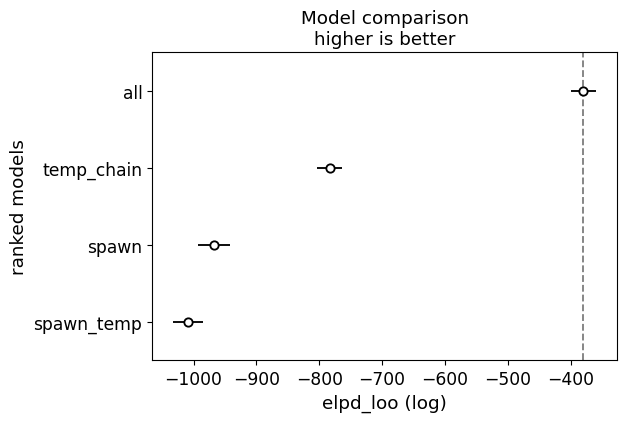

In [9]:
az.plot_compare(az.compare({
    "all": idata_all,
    "temp_chain": idata_temp_chain,
    "spawn": idata_spawn,
    "spawn_temp": idata_spawn_temp,
}))

#### PPC
Well, we're definitely not overfitting with all of the climate variables. It did *significantly* better than only looking at temperature. Hopefully that should mean that this model is significantly more useful than my last project. Let's take a quick look at the PPC.

<Axes: xlabel='biome'>

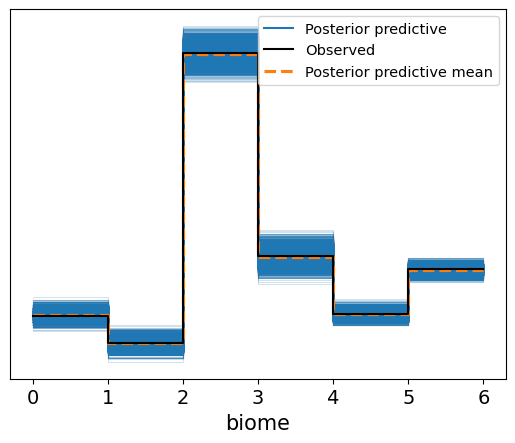

In [10]:
model_all.predict(idata_all, kind="response")
az.plot_ppc(idata_all)

#### Analysis
Well that looks pretty good. Overall this makes a *lot* of sense. In fact, it almost makes... too much sense. In fact, looking at it, we've basically just made an ideal model. We used the climate variables of the village's biome to predict the villages biome. In fact, if we know those variables, the village's biome is actually deterministic. To make this model actually useful, we shouldn't take those into account. Let's try another one, with only the origin and spawn variables (note that this will certainly be worse, but more useful).

Unfortunately, I've already tried with just the spawn variables and it did significantly worse. We'll see if including the origin variables does any better.

In [13]:
# depth is constant; removed
model_not_village = bmb.Model("biome ~  temperature + humidity + continentalness + erosion + weirdness + originTemperature + originHumidity + originContinentalness + originErosion + originWeirdness + (temperature|originTemperature) + (humidity|originHumidity) + (continentalness|originContinentalness) + (erosion|originErosion) + (weirdness|originWeirdness)", data=data, family="categorical")
idata_not_village = model_not_village.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, temperature, humidity, continentalness, erosion, weirdness, originTemperature, originHumidity, originContinentalness, originErosion, originWeirdness, 1|originTemperature_sigma, 1|originTemperature_offset, temperature|originTemperature_sigma, temperature|originTemperature_offset, 1|originHumidity_sigma, 1|originHumidity_offset, humidity|originHumidity_sigma, humidity|originHumidity_offset, 1|originContinentalness_sigma, 1|originContinentalness_offset, continentalness|originContinentalness_sigma, continentalness|originContinentalness_offset, 1|originErosion_sigma, 1|originErosion_offset, erosion|originErosion_sigma, erosion|originErosion_offset, 1|originWeirdness_sigma, 1|originWeirdness_offset, weirdness|originWeirdness_sigma, weirdness|originWeirdness_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 466 seconds.
There were 298 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

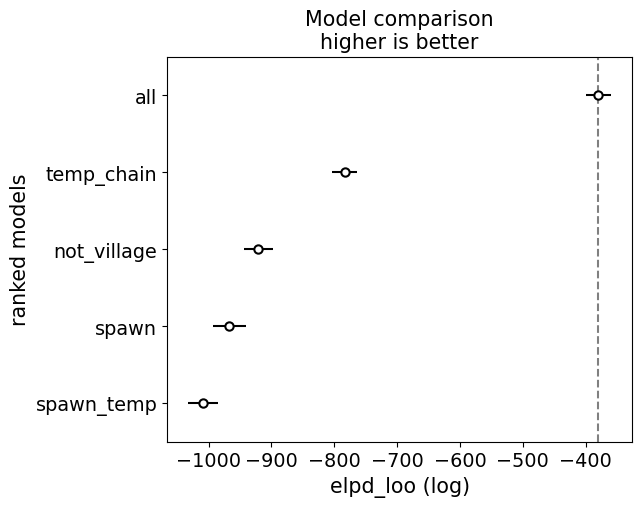

In [17]:
az.plot_compare(az.compare({
    "all": idata_all,
    "not_village": idata_not_village,
    "temp_chain": idata_temp_chain,
    "spawn": idata_spawn,
    "spawn_temp": idata_spawn_temp,
}))

#### Comparison and PPC
Well I think this shows quite clearly what's going on. The `temp_chain` model has access to `villageTemperature` (one of the climate variables at the village); it is better at predicting the village's biome. However, it's notable that knowing the origin parameters is definitely helpful. This makes sense, as it gives the model some sense of how the climate changes through having two data points rather than just the one. Before making any conclusions, let's look at the PPCs.

<Axes: xlabel='biome'>

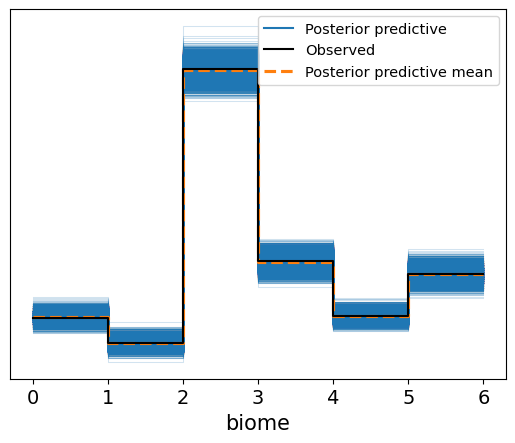

In [15]:
model_not_village.predict(idata_not_village, kind="response")
az.plot_ppc(idata_not_village)

<Axes: xlabel='biome'>

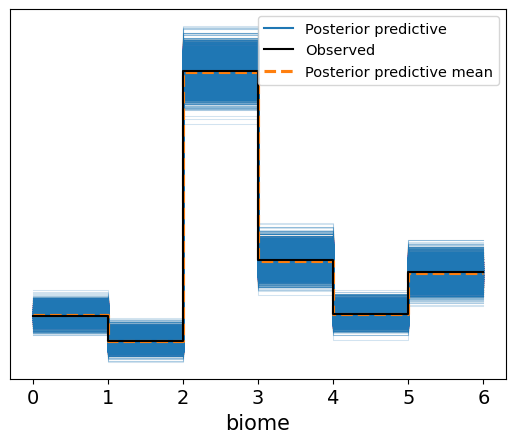

In [16]:
model_spawn.predict(idata_spawn, kind="response")
az.plot_ppc(idata_spawn)

#### Conclusions
The means for both of these are basically exactly as good as the one with all the variables. That's good news, and means that these more useful models should still be very accurate. The only major difference is that the blue lines vary further from the mean/observed in the models with less data.

Based on that, I think the final one is actually the most useful, despite being the least accurate. The mean is still right on, and collecting those variables is much easier (and quicker). This is certainly more useful than the prior project, which A) only predicted temperature, and B) wasn't that accurate. It is definitely very interesting that you can very accurately predict the village biome based solely on spawn climate variables.

Overall I feel like this data is pretty nicely wrapped up. I feel like I understand the connections between the variables and what is at play, and have a good understanding of the pros and cons of each model.